In [112]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

from imblearn.over_sampling import RandomOverSampler


np.random.seed(42)


In [113]:
train_data = pd.read_csv('prepared_training_data.csv')
test_data = pd.read_csv('prepared_test_data.csv')

y_train = train_data.casualty_severity
X_train = train_data.drop('casualty_severity', axis=1)

y_test = test_data.casualty_severity
X_test = test_data.drop('casualty_severity', axis=1)

In [114]:
ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [115]:
X_train.shape

(16528, 85)

## Data preprocessing

We need to scale our numeric data so that we don't get overweighting in some models. We will use a MinMaxScaler to scale between 0 and 1, meaning that we won't affect our One-Hot Encoded columns

In [116]:
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [117]:
pd.DataFrame(X_train_scaled, columns=X_train.columns)

,number_of_vehicles,number_of_casualties,day_of_week,first_road_class,speed_limit,second_road_class,urban_or_rural_area,sex_of_casualty,age_band_of_casualty,casualty_imd_decile,...,casualty_type_Goods vehicle passenger,casualty_type_Motorcycle passenger,casualty_type_Motorcycle rider,casualty_type_Other vehicle occupant,casualty_type_Pedestrian,casualty_type_Public transport driver,casualty_type_Public transport passenger,casualty_home_area_type_Rural,casualty_home_area_type_Small town,casualty_home_area_type_Urban area
0,1.000000,0.0,0.714286,0.6,0.2,0.166667,0.0,0.0,0.5,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.666667,0.5,0.714286,0.0,0.4,0.166667,0.0,1.0,0.7,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.666667,0.5,0.714286,0.0,0.4,0.166667,0.0,1.0,0.7,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.666667,0.5,0.714286,0.0,0.4,0.166667,0.0,1.0,0.7,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.666667,0.0,1.000000,0.0,0.8,0.166667,1.0,0.0,0.6,0.444444,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16523,0.666667,0.0,0.285714,0.6,0.2,0.166667,0.0,0.0,0.3,0.111111,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16524,0.666667,0.0,0.571429,0.6,0.2,0.166667,0.0,1.0,1.0,0.888889,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
16525,0.666667,0.0,0.571429,0.4,0.2,0.166667,0.0,1.0,0.5,0.222222,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
16526,0.333333,0.0,0.428571,0.0,0.2,0.000000,0.0,0.0,0.7,0.777778,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## Elena is fucking around with feature selection

In [118]:
from sklearn.feature_selection import SelectKBest, chi2
k =  10
reduced_feats = SelectKBest(chi2, k=k).fit(X_train_scaled, y_train)
cols = reduced_feats.get_feature_names_out()
X_train_scaled = pd.DataFrame(SelectKBest(chi2, k=k).fit_transform(X_train_scaled, y_train), columns=cols)
X_test_scaled = X_test_scaled[cols]

In [119]:
cols

array(['sex_of_casualty', 'time_nighttime', 'road_type_Dual carriageway',
       'junction_detail_Roundabout',
       'pedestrian_location_In carriageway, crossing elsewhere',
       "pedestrian_movement_Crossing from driver's nearside",
       "pedestrian_movement_Crossing from driver's offside",
       'casualty_type_Car driver', 'casualty_type_Motorcycle rider',
       'casualty_type_Pedestrian'], dtype=object)

## Initial modelling

In [120]:
def evaluate_model(model_class, X_train=X_train_scaled, y_train=y_train):

    cv = 5
    # K fold cross validation and predict on test data
    accuracy_scores = cross_val_score(model_class, X_train, y_train.to_numpy().ravel(), cv=cv, scoring='accuracy') * 100
    precision_scores = cross_val_score(model_class, X_train, y_train.to_numpy().ravel(), cv=cv, scoring='precision') * 100
    recall_scores = cross_val_score(model_class, X_train, y_train.to_numpy().ravel(), cv=cv, scoring='recall') * 100
    f1_scores = cross_val_score(model_class, X_train, y_train.to_numpy().ravel(), cv=cv, scoring='f1') * 100
    

    metrics_dict = {
        'Model Type': model_class,
        'CV_mean_accuracy': accuracy_scores.mean(), 
        'CV_mean_precision': precision_scores.mean(), 
        'CV_mean_recall': recall_scores.mean(), 
        'CV_mean_F1': f1_scores.mean()
        
       
    }   

    return metrics_dict

In [121]:
models = {'SVC': SVC(kernel='rbf'), 'KNN': KNeighborsClassifier(), 'Logistic Regression': LogisticRegression(), 'Random Forest': RandomForestClassifier(), 'XGBoost': XGBClassifier()}  
model_metric_dict = {}


In [122]:
for key, values in models.items():
  metrics_dict = evaluate_model(values)
  model_metric_dict.update({key: metrics_dict})

results = pd.DataFrame.from_dict(model_metric_dict).T

# results['combined_score'] = (results.CV_mean_accuracy + results.CV_mean_precision + results.CV_mean_recall + results.CV_mean_F1) / 4
results.sort_values(by='CV_mean_accuracy', ascending=False)

,Model Type,CV_mean_accuracy,CV_mean_precision,CV_mean_recall,CV_mean_F1
Logistic Regression,LogisticRegression(),60.963216,62.083122,56.49793,59.138338
SVC,SVC(),60.805949,61.402849,58.264715,59.784527
XGBoost,"XGBClassifier(base_score=None, booster=None, c...",60.799899,61.431805,58.11951,59.718567
Random Forest,RandomForestClassifier(),60.715184,61.252447,58.095333,59.866641
KNN,KNeighborsClassifier(),54.870581,66.586344,21.707864,30.38381


In [123]:
# from sklearn.model_selection import GridSearchCV

# param_grid = { 
#     'n_estimators': [100, 200, 300],
#     'max_features': [None, 'sqrt', 'log2'],
#     'max_depth': [3,5,10,20,None],
#     'criterion' :['gini']
# }

# gd=GridSearchCV(estimator=RandomForestClassifier(random_state=0),param_grid=param_grid,verbose=True, cv=2)
# gd.fit(X_train_scaled, y_train)

# print(gd.best_score_)
# print(gd.best_params_)

In [124]:
from sklearn.metrics import accuracy_score, classification_report

model = RandomForestClassifier(random_state=0, class_weight='balanced')
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

score=accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.66      0.72      2059
           1       0.39      0.54      0.45       813

    accuracy                           0.63      2872
   macro avg       0.59      0.60      0.58      2872
weighted avg       0.67      0.63      0.64      2872



In [125]:
y_pred_train = model.predict(X_train_scaled)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.61      0.65      0.63      8264
           1       0.63      0.58      0.60      8264

    accuracy                           0.62     16528
   macro avg       0.62      0.62      0.61     16528
weighted avg       0.62      0.62      0.61     16528



In [126]:
confusion_matrix(y_test, y_pred)
#

array([[1354,  705],
       [ 370,  443]], dtype=int64)

In [127]:
confusion_matrix(y_train, y_pred_train)


array([[5409, 2855],
       [3499, 4765]], dtype=int64)

In [128]:
y_prob_train = model.predict_proba(X_train_scaled)[:, 1]
y_prob_test =  model.predict_proba(X_test_scaled)[:, 1]

Text(0.5, 1.0, 'Train Precision-Recall curve')

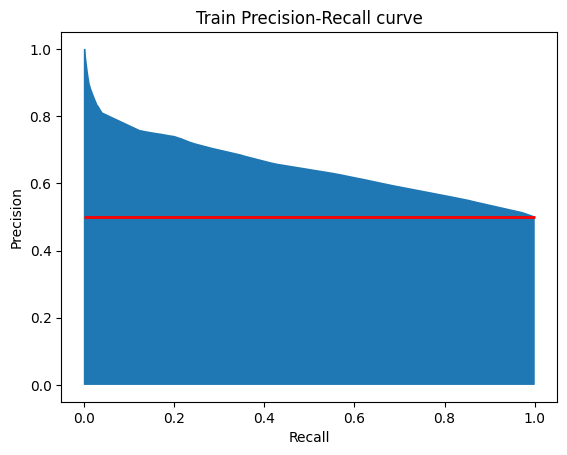

In [129]:
baseline = len(y_train[y_train==1]) / len(y_train)
fig, ax = plt.subplots()
precision, recall, thresholds = precision_recall_curve(y_train, y_prob_train)
ax.fill_between(recall, precision)
ax.set_ylabel("Precision")
ax.set_xlabel("Recall")
ax.hlines(y=baseline, xmin=0, xmax=1, linewidth=2, color='r', label='baseline')
ax.set_title("Train Precision-Recall curve")

Text(0.5, 1.0, 'Test Precision-Recall curve')

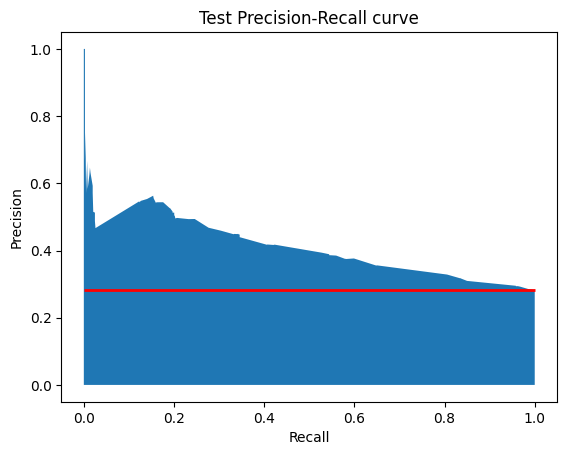

In [130]:
baseline = len(y_test[y_test==1]) / len(y_test)
fig, ax = plt.subplots()
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_test)
ax.fill_between(recall, precision)
ax.set_ylabel("Precision")
ax.set_xlabel("Recall")
ax.hlines(y=baseline, xmin=0, xmax=1, linewidth=2, color='r', label='baseline')
ax.set_title("Test Precision-Recall curve")

In [131]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X_test_scaled.columns)

In [132]:
forest_importances = forest_importances.nlargest(20)

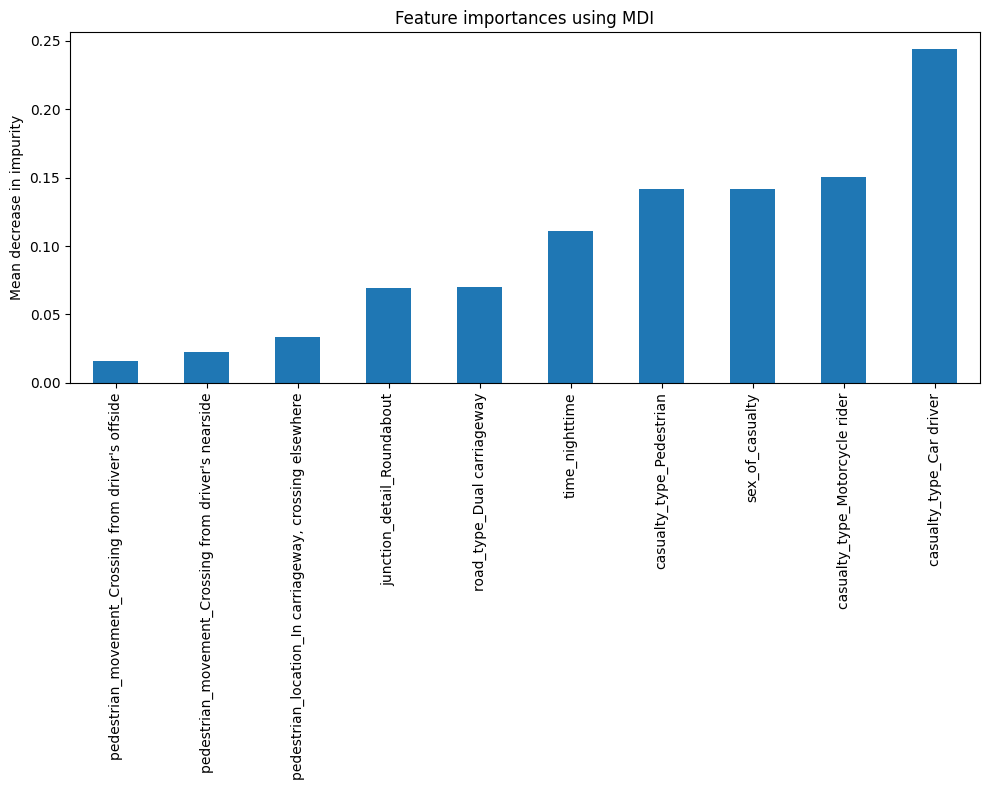

In [133]:
fig, ax = plt.subplots(figsize=(10,8))
# yerr=std
forest_importances.sort_values().plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [134]:
X_test['Actual'] = y_test
X_test['Predicted'] = y_pred

In [135]:
incorrect = X_test[X_test.Actual != X_test.Predicted]
correct = X_test[X_test.Actual == X_test.Predicted]

In [136]:
for col in incorrect.columns:
  print(incorrect[col].value_counts(normalize=True).sort_index() / X_test[col].value_counts(normalize=True).sort_index())

number_of_vehicles
0         NaN
1    1.338871
2    0.879397
3    0.746979
Name: proportion, dtype: float64
number_of_casualties
1    1.114944
2    0.784840
3    0.806095
4    0.864350
5    1.567355
Name: proportion, dtype: float64
day_of_week
0    0.923968
1    0.969054
2    0.926452
3    1.038633
4    1.067620
5    1.040657
7    0.993715
Name: proportion, dtype: float64
first_road_class
1    1.145878
2    1.502791
3    1.008161
4    0.894904
5    0.397902
6    0.546026
Name: proportion, dtype: float64
speed_limit
20    1.144983
30    1.068977
40    0.911838
50    1.064123
60    1.084522
70    0.420534
Name: proportion, dtype: float64
second_road_class
0    0.988164
1    1.020035
2    1.027549
3    1.106221
4    0.890543
5         NaN
6    1.335814
Name: proportion, dtype: float64
urban_or_rural_area
0    1.031856
1    0.926452
Name: proportion, dtype: float64
sex_of_casualty
0    1.130068
1    0.800072
Name: proportion, dtype: float64
age_band_of_casualty
0     1.510051
1     1.81406

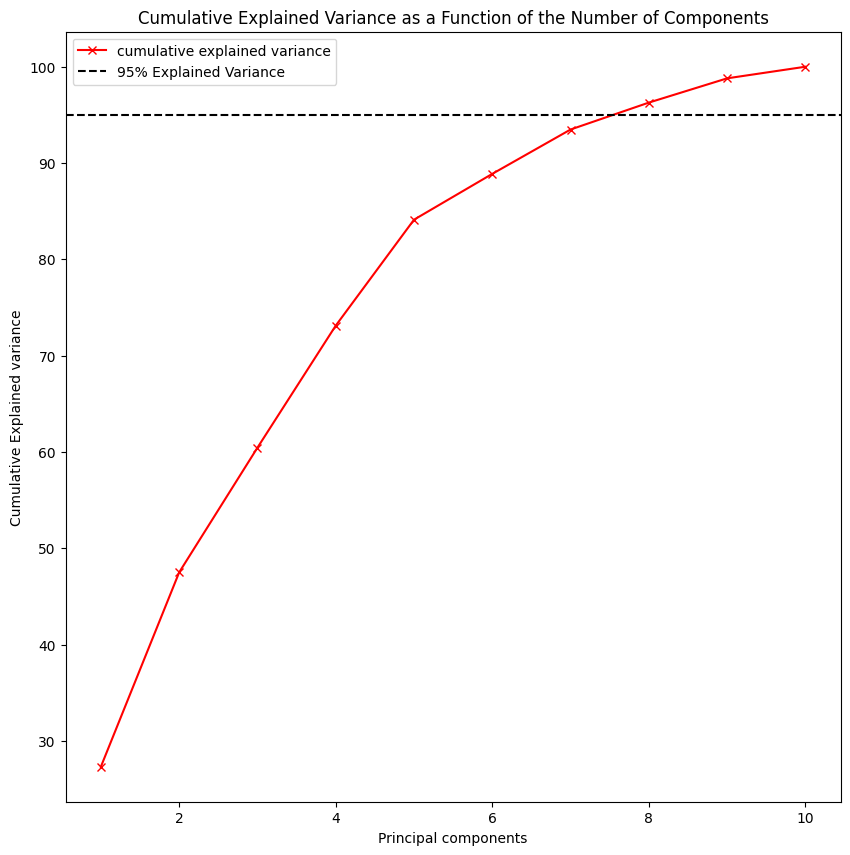

In [137]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train_scaled)
cumsum = np.cumsum(pca.explained_variance_ratio_)*100
d = [n+1 for n in range(len(cumsum))]
plt.figure(figsize=(10, 10))
plt.plot(d,cumsum, marker='x', color = 'red',label='cumulative explained variance')
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axhline(y = 95, color='k', linestyle='--', label = '95% Explained Variance')
# plt.xlim(0,20)
plt.legend(loc='best')

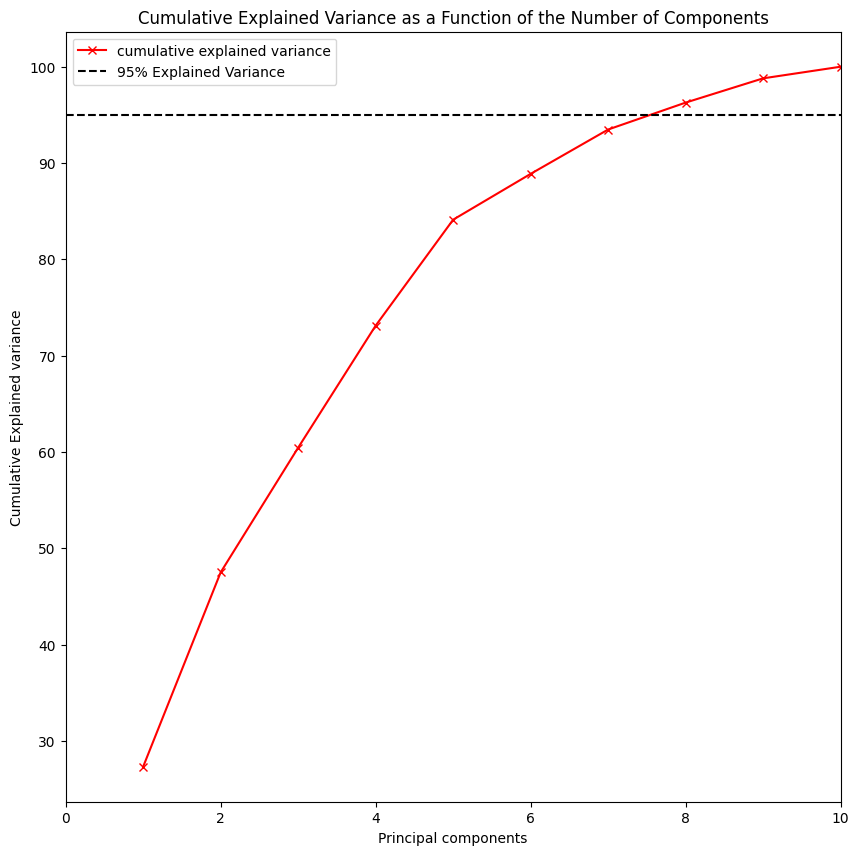

In [138]:
plt.figure(figsize=(10, 10))
plt.plot(d,cumsum, marker='x', color = 'red',label='cumulative explained variance')
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axhline(y = 95, color='k', linestyle='--', label = '95% Explained Variance')
plt.xlim(0,10)
plt.legend(loc='best')